In [ ]:
!wget https://github.com/Jannetty/Neurogen_ODE_Models/raw/main/wt_cellcycle_durations.xlsx -O wt_cellcycle_durations.xlsx

In [272]:
import pandas as pd
import numpy as np
import datetime
from dateutil.parser import parse
import seaborn as sns
import matplotlib.pyplot as plt
import inspect

df_raw = pd.read_excel("wt_cellcycle_durations.xlsx", header=None, engine="openpyxl")

# assign column names and set index
df_raw.columns = ['Division'] + list(range(1, df_raw.shape[1]))
df_raw.set_index('Division', inplace=True)

# convert to hours
def value_to_hours(val):
    if pd.isna(val):
        return np.nan

    # datetime.datetime or pandas Timestamp
    if isinstance(val, (datetime.datetime, pd.Timestamp)):
        return val.hour + val.minute / 60 + val.second / 3600

    # excel sometimes uses datetime.time
    if isinstance(val, datetime.time):
        return val.hour + val.minute / 60 + val.second / 3600

    # excel may store durations as fraction of a day
    if isinstance(val, (float, int)) and 0 <= val < 1:
        return val * 24

    return np.nan

df_hours = df_raw.applymap(value_to_hours)

df_hours = df_hours.reset_index()
# drop rows where 'Division' is missing/blank BEFORE extracting
df_hours = df_hours[df_hours['Division'].notna()]

df_hours["Division Number"] = (
    df_hours["Division"].astype(str).str.extract(r"(\d+)")[0].astype(float)
)
df_hours = df_hours.dropna(subset=["Division Number"])
df_hours["Division Number"] = df_hours["Division Number"].astype(int)

# set index and collapse duplicate division rows
df_hours = (
    df_hours.drop(columns=["Division"])
            .set_index("Division Number")
            .groupby(level=0).first()
            .sort_index()
)

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/1267802920.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hours = df_raw.applymap(value_to_hours)


In [265]:
df_hours

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
Division Number,,,,,,,,,,,,,,,,,,,,,
1,4.733333,4.866667,2.700000,1.966667,2.400000,1.333333,2.000000,2.250000,1.916667,2.583333,...,1.416667,0.916667,1.416667,1.083333,1.750000,2.666667,0.916667,1.083333,0.750000,4.000000
2,5.600000,5.333333,3.333333,2.000000,2.733333,1.833333,2.500000,1.916667,1.916667,3.083333,...,1.750000,1.000000,1.583333,1.166667,2.166667,2.916667,1.000000,1.500000,0.916667,3.583333
3,NaN,NaN,3.966667,2.266667,3.000000,2.333333,3.083333,1.916667,2.083333,3.666667,...,2.333333,1.083333,1.916667,1.250000,2.333333,3.416667,1.333333,1.916667,1.166667,NaN
4,NaN,NaN,NaN,2.700000,NaN,2.750000,NaN,NaN,1.916667,NaN,...,2.916667,1.166667,2.000000,1.250000,2.750000,3.666667,1.250000,2.333333,1.333333,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.666667,1.166667,2.333333,1.166667,3.083333,NaN,1.416667,2.750000,1.416667,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.083333,2.500000,1.083333,NaN,NaN,1.750000,NaN,1.500000,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.250000,3.083333,1.333333,NaN,NaN,2.000000,NaN,1.750000,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.166667,NaN,1.333333,NaN,NaN,2.666667,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.250000,NaN,1.666667,NaN,NaN,NaN,NaN,NaN,NaN


In [266]:
# compute mean and standard deviation for each division
mean_durations = df_hours.mean(axis=1)
std_durations = df_hours.std(axis=1)
summary = pd.DataFrame({
    "Mean Duration (hrs)": mean_durations,
    "Std Dev (hrs)": std_durations
})

print(summary)

                 Mean Duration (hrs)  Std Dev (hrs)
Division Number                                    
1                           2.016667       1.135619
2                           2.276667       1.249435
3                           2.298485       0.961383
4                           2.241667       0.974679
5                           2.068182       0.839823
6                           1.864583       0.742606
7                           1.805556       0.686510
8                           1.729167       0.671424
9                           1.666667       0.416667


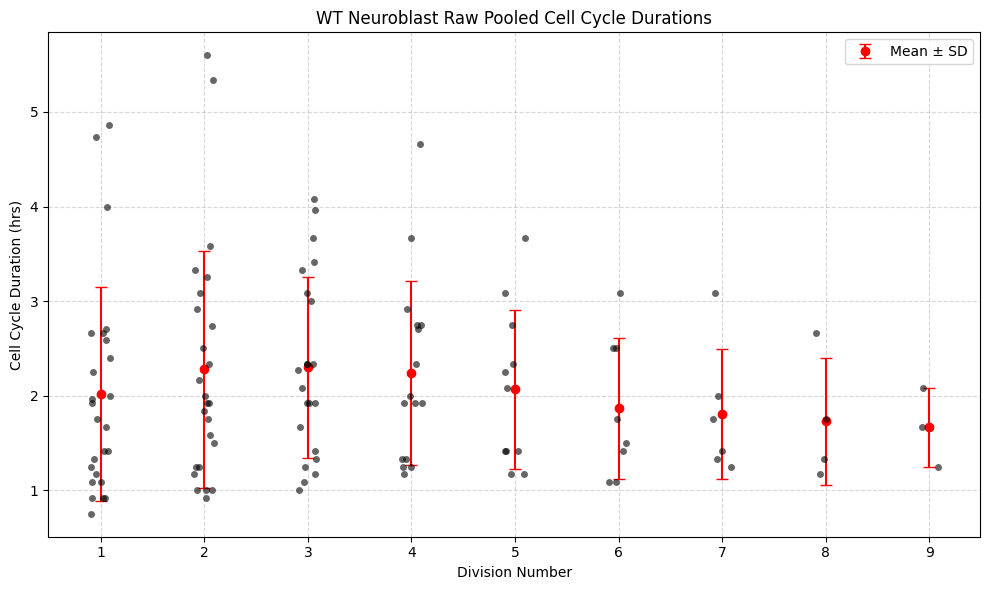

In [267]:
# melt the wide-format DataFrame to long format
df_long = df_hours.reset_index().melt(id_vars="Division Number",
                                      var_name="Cell",
                                      value_name="Duration (hrs)")
df_long = df_long.dropna()

# compute summary stats
summary = df_long.groupby("Division Number")["Duration (hrs)"].agg(["mean", "std"])

# get the unique division numbers in the order Seaborn will plot them
division_order = sorted(df_long["Division Number"].unique())

# map division numbers to their categorical x positions
x_positions = list(range(len(division_order)))
mean_values = summary.loc[division_order, "mean"]
std_values = summary.loc[division_order, "std"]


plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long, x="Division Number", y="Duration (hrs)",
              jitter=True, alpha=0.6, color='black', order=division_order)
plt.errorbar(x_positions, mean_values, yerr=std_values,
             fmt='o', color='red', capsize=4, label="Mean ± SD")

# final plot setup
plt.title("WT Neuroblast Raw Pooled Cell Cycle Durations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Division Number")
plt.ylabel("Cell Cycle Duration (hrs)")
plt.legend()
plt.tight_layout()
plt.show()

In [268]:
# need to normalize to first division time
df_norm = df_hours.copy()
for cell in df_norm.columns:
    first_div = df_norm[cell].dropna().iloc[0]
    df_norm[cell] = df_norm[cell] / first_div

mean_durations = df_norm.mean(axis=1)
std_durations = df_norm.std(axis=1)
summary = pd.DataFrame({
    "Mean Duration (relative to first division)": mean_durations,
    "Std Dev (relative to first division)": std_durations
})

print(summary)


                 Mean Duration (relative to first division)  \
Division Number                                               
1                                                  1.000000   
2                                                  1.142683   
3                                                  1.382767   
4                                                  1.625310   
5                                                  1.768257   
6                                                  1.751324   
7                                                  1.805247   
8                                                  1.830420   
9                                                  1.724942   

                 Std Dev (relative to first division)  
Division Number                                        
1                                            0.000000  
2                                            0.138052  
3                                            0.266242  
4                         

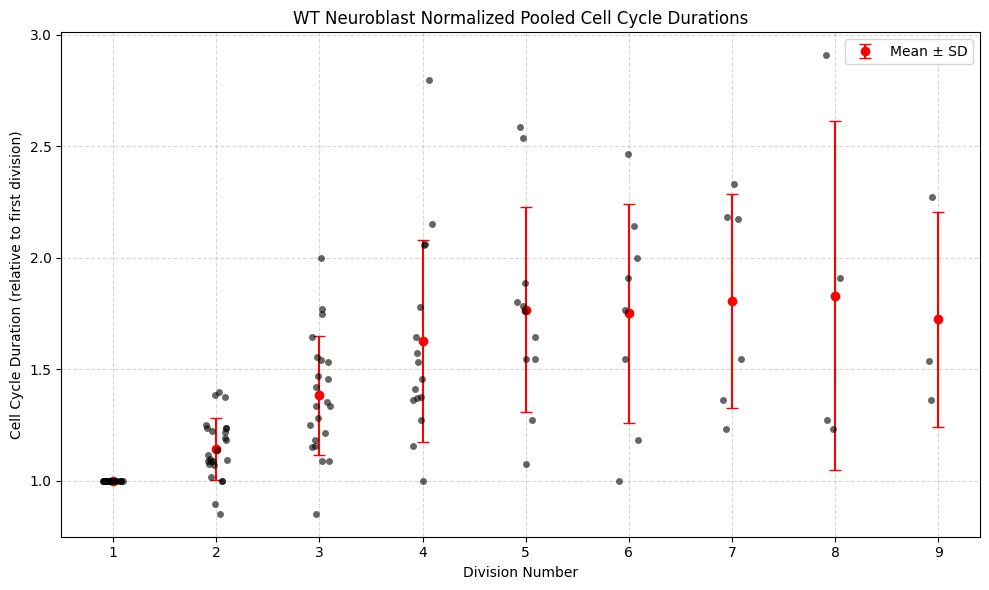

In [269]:
df_long = df_norm.reset_index().melt(id_vars="Division Number", 
                                      var_name="Cell", 
                                      value_name="Duration (relative to first division)")
df_long = df_long.dropna()

summary = df_long.groupby("Division Number")["Duration (relative to first division)"].agg(["mean", "std"])

division_order = sorted(df_long["Division Number"].unique())

x_positions = list(range(len(division_order)))
mean_values = summary.loc[division_order, "mean"]
std_values = summary.loc[division_order, "std"]

plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long, x="Division Number", y="Duration (relative to first division)",
              jitter=True, alpha=0.6, color='black', order=division_order)
plt.errorbar(x_positions, mean_values, yerr=std_values,
             fmt='o', color='red', capsize=4, label="Mean ± SD")

plt.title("WT Neuroblast Normalized Pooled Cell Cycle Durations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Division Number")
plt.ylabel("Cell Cycle Duration (relative to first division)")
plt.legend()
plt.tight_layout()
plt.show()

Fit models to each cell's profile individually

In [273]:
from collections import defaultdict
from scipy.optimize import curve_fit
import warnings

# ensure df_hours is clean (index and columns as int)
# force the dtypes to avoid string/int mismatches:
df_hours.index = pd.Index(df_hours.index).astype(int)
try:
    df_hours.columns = pd.Index(df_hours.columns).astype(int)
except Exception:
    # if some columns can’t cast, coerce safely by mapping
    df_hours.columns = pd.to_numeric(df_hours.columns, errors='coerce').astype(int)

# normalize per cell by the first value
df_norm = df_hours.copy()
for cell in df_norm.columns:
    y = df_norm[cell].dropna()
    if y.empty:
        continue
    first = y.iloc[0]  # first non-NaN division for this cell
    if first and np.isfinite(first) and first != 0:
        df_norm[cell] = df_norm[cell] / first
    else:
        # if first is 0 or NaN, skip normalization for this cell
        pass

# Keep dtypes consistent
df_norm.index = pd.Index(df_norm.index).astype(int)
df_norm.columns = pd.Index(df_norm.columns).astype(int)

# define models and registry with min points
def linear(x, a, b): return a*x + b
def logarithmic(x, a, b): return a*np.log(x) + b  # x>0
def quadratic(x, a, b, c): return a*x**2 + b*x + c
def cubic(x, a, b, c, d): return a*x**3 + b*x**2 + c*x + d
def exponential_decay(x, a, b, c): return a*np.exp(-b*x) + c

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

# since data are normalized (1 at first division), use a stable p0 for exponential
MODEL_REGISTRY = {
    "Linear":            (linear,             2, None),
    "Logarithmic":       (logarithmic,        2, None),          # divisions start at 1, so fine
    "Quadratic":         (quadratic,          3, None),
    "Cubic":             (cubic,              4, None),
    "Exponential Decay": (exponential_decay,  3, [0.5, 0.3, 1.0]),  # (a,b,c): c≈1 baseline after norm
}

# per-cell fits
per_cell_fit_results = defaultdict(dict)

for cell in df_norm.columns:
    y_series = df_norm[cell].dropna()
    if y_series.empty:
        continue
    x = y_series.index.values.astype(float)
    y = y_series.values

    # need at least 2 distinct x’s for any fit
    if np.unique(x).size < 2:
        continue

    for name, (func, min_pts, p0) in MODEL_REGISTRY.items():
        if len(x) < min_pts:
            continue
        try:
            params, _ = curve_fit(func, x, y, p0=p0, maxfev=10000)
            yhat = func(x, *params)
            r2 = r_squared(y, yhat)
            per_cell_fit_results[name][int(cell)] = {"params": params, "r2": float(r2)}
        except Exception:
            continue

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/3206175035.py:70: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(func, x, y, p0=p0, maxfev=10000)


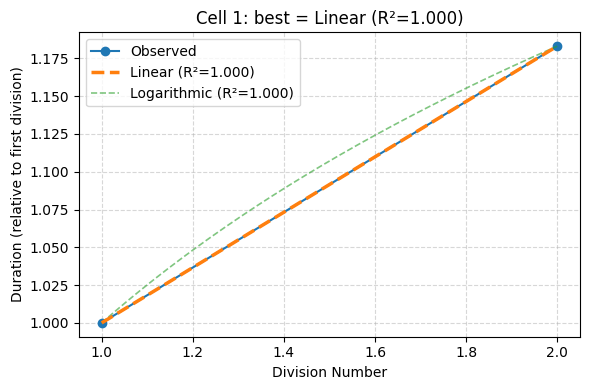

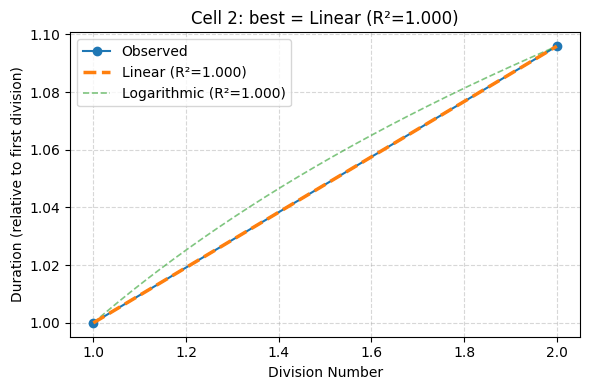

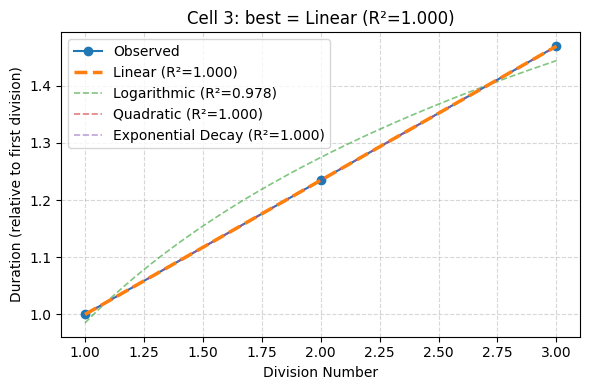

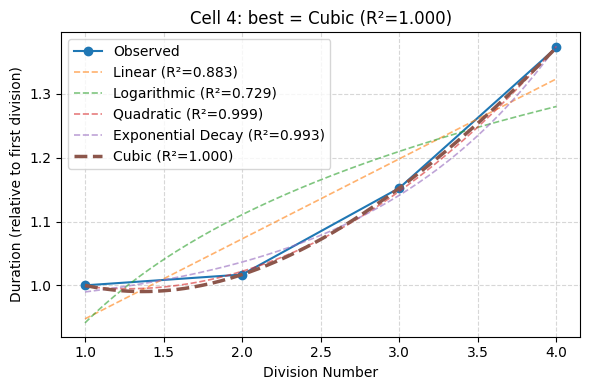

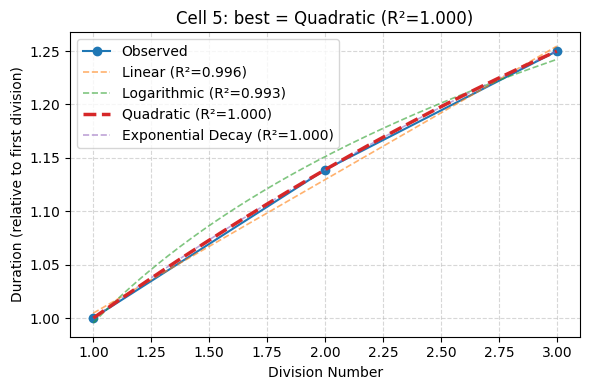

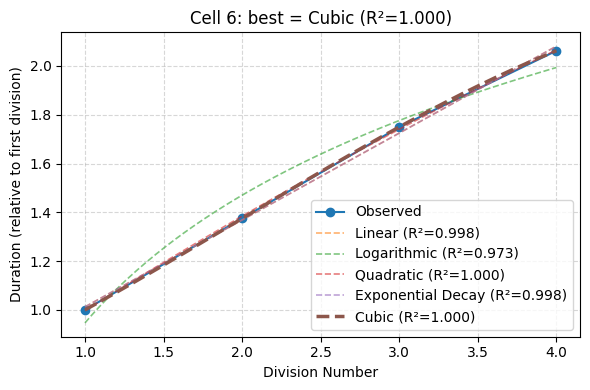

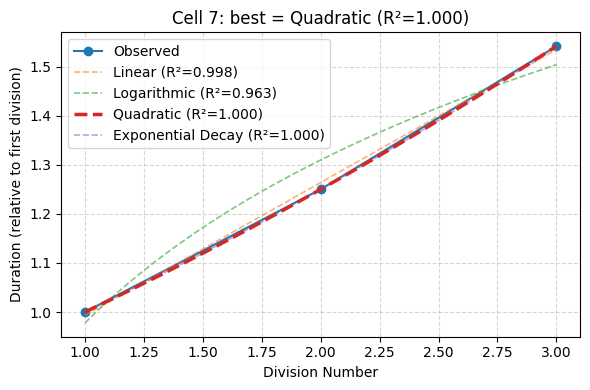

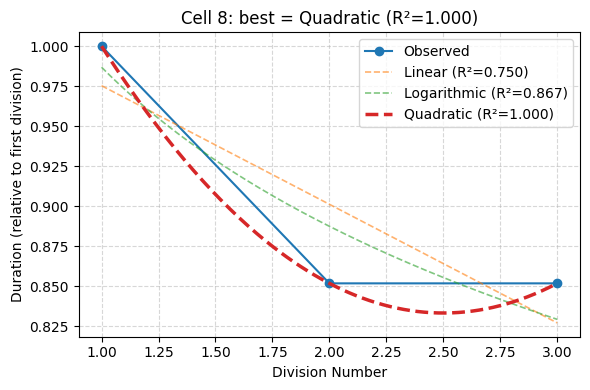

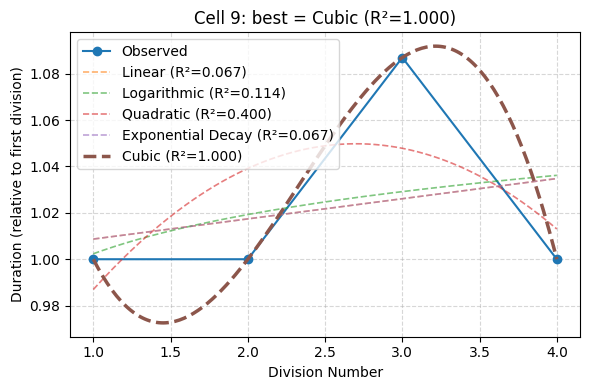

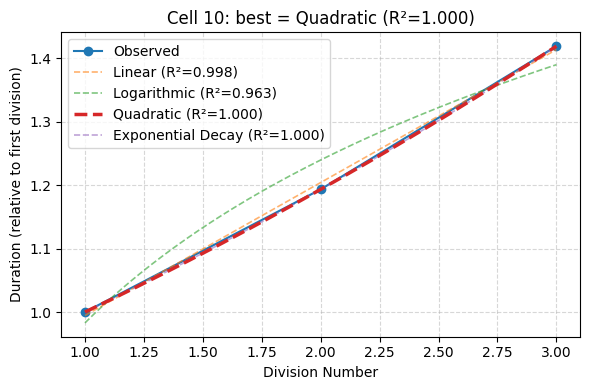

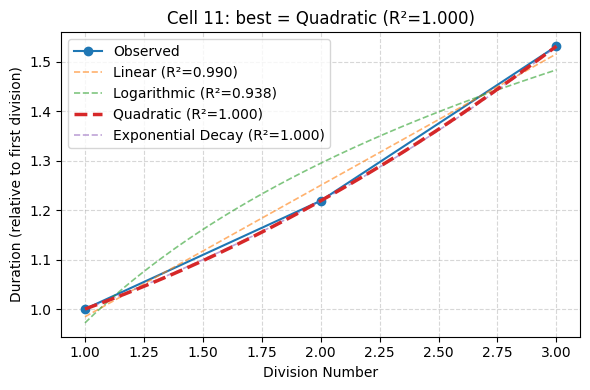

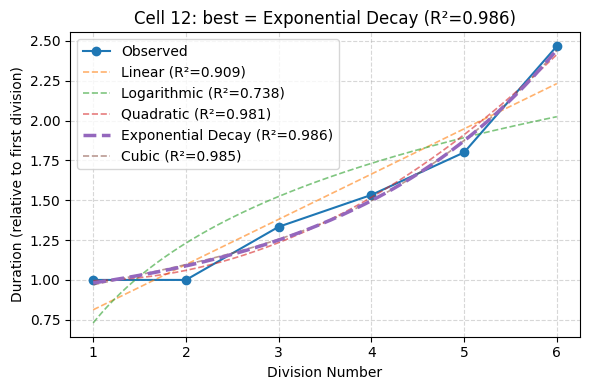

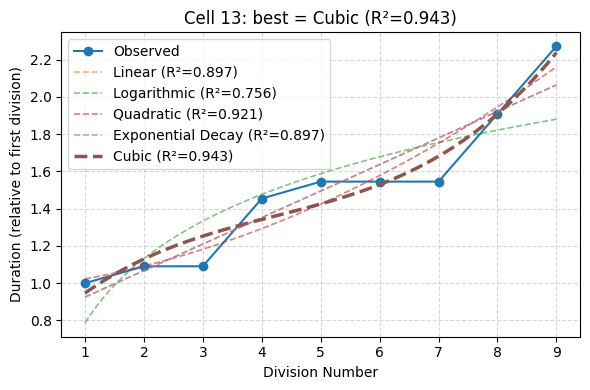

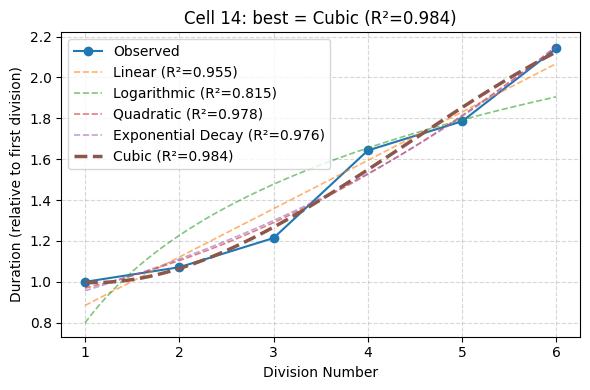

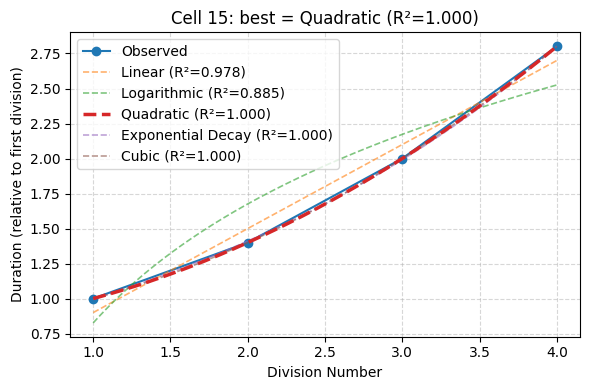

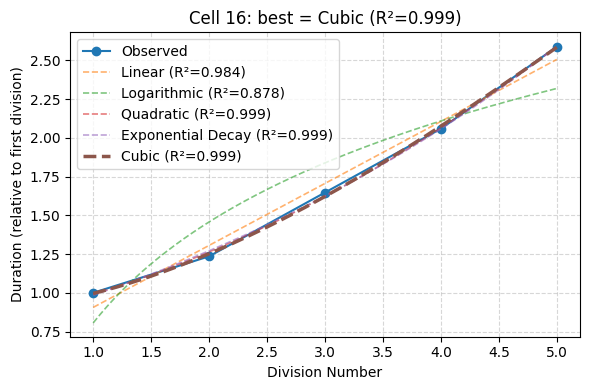

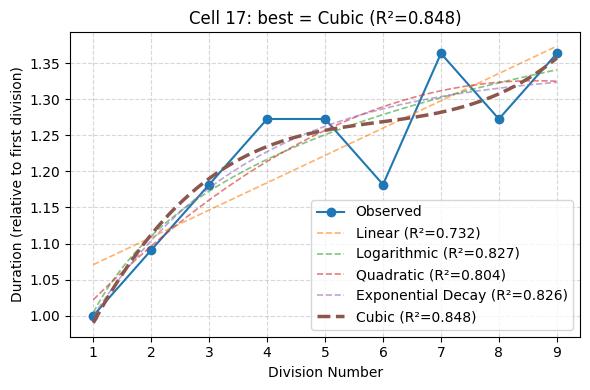

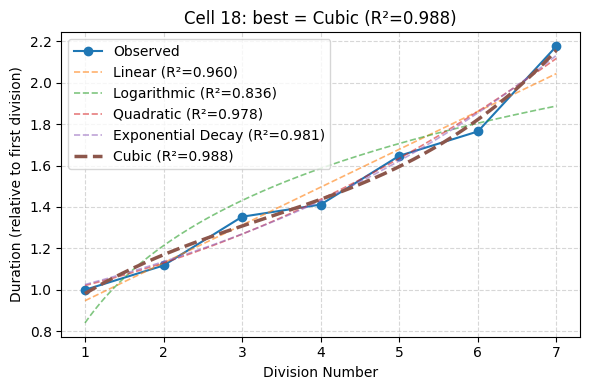

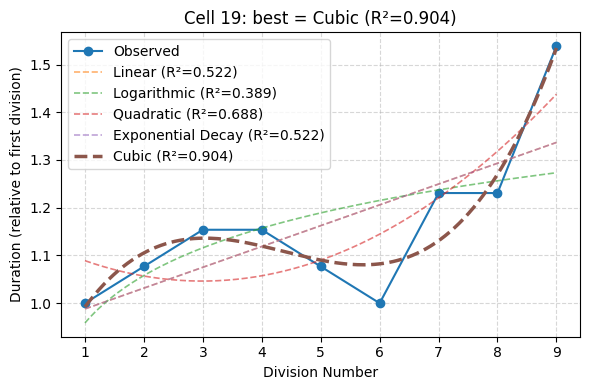

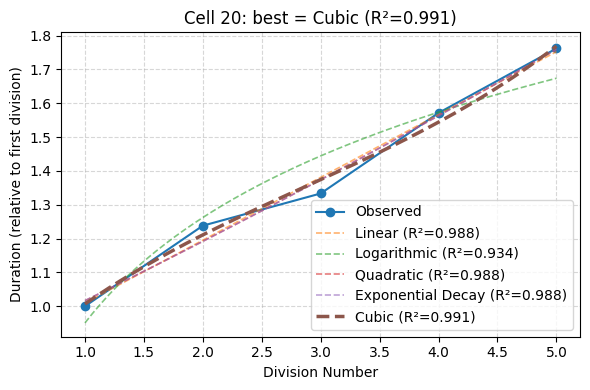

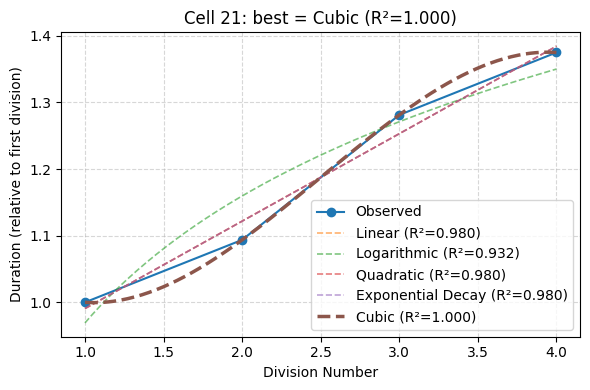

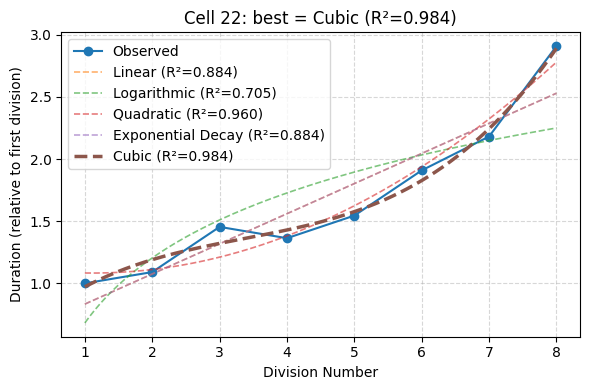

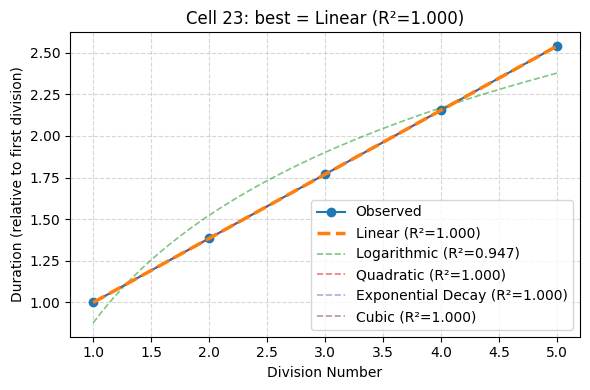

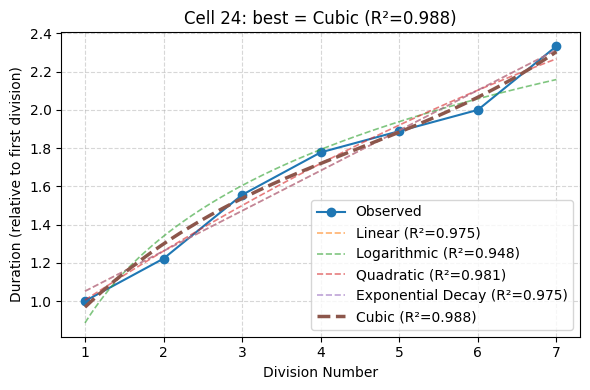

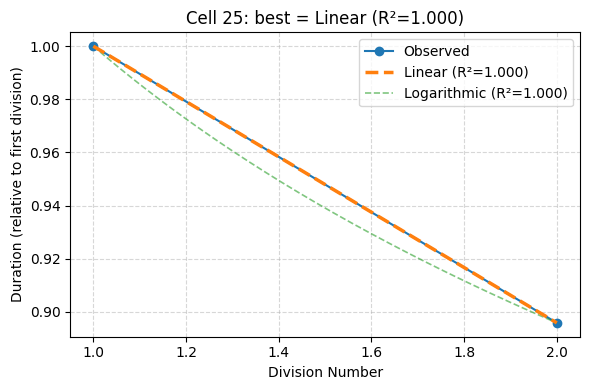

In [274]:
def plot_cell_best_and_all_models(cell_id):
    # observed
    y_series = df_norm[cell_id].dropna()
    if y_series.empty:
        print(f"No data for cell {cell_id}")
        return
    x = y_series.index.astype(float).values
    y = y_series.values

    # models available for this cell
    available = {name: res[cell_id]
                 for name, res in per_cell_fit_results.items()
                 if cell_id in res and np.isfinite(res[cell_id].get("r2", np.nan))}

    if not available:
        print(f"No fitted models for cell {cell_id}, too few points")
        return

    # function lookup
    name_to_func = {
        "Linear": linear,
        "Logarithmic": logarithmic,
        "Quadratic": quadratic,
        "Cubic": cubic,
        "Exponential Decay": exponential_decay,
    }

    # pick best by R²
    best_name, best_res = max(available.items(), key=lambda kv: kv[1]["r2"])

    # plot
    import matplotlib.pyplot as plt
    xfit = np.linspace(x.min(), x.max(), 200)
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, 'o-', label="Observed")

    # plot all models; highlight best
    for name, res in available.items():
        func = name_to_func[name]
        yfit = func(xfit, *res["params"])
        is_best = (name == best_name)
        plt.plot(
            xfit, yfit, '--',
            linewidth=2.5 if is_best else 1.2,
            alpha=1.0 if is_best else 0.6,
            label=f"{name} (R²={res['r2']:.3f})",
            zorder=3 if is_best else 2
        )

    plt.title(f"Cell {cell_id}: best = {best_name} (R²={best_res['r2']:.3f})")
    plt.xlabel("Division Number")
    plt.ylabel("Duration (relative to first division)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

for cid in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]:
    if cid in df_norm.columns:
        plot_cell_best_and_all_models(cid)

fit models to pooled global data

In [275]:
def _num_params(func):
    """Number of free params (excludes x)."""
    return max(0, len(inspect.signature(func).parameters) - 1)

def _r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

def _adj_r2(r2, n, p):
    # n = points, p = number of parameters (excluding x)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

def _loocv_mse(x, y, func, p0=None, maxfev=10000):
    """
    Leave-One-Out CV MSE. Skips folds that can't fit (e.g., too few points).
    Returns (mse, n_successful_folds).
    """
    n = len(x)
    errs = []
    successes = 0
    p = _num_params(func)

    for i in range(n):
        mask = np.ones(n, dtype=bool); mask[i] = False
        xi, yi = x[mask], y[mask]
        # Need at least p+1 points to fit on the training split
        if len(xi) < p + 1:
            continue
        try:
            params, _ = curve_fit(func, xi, yi, p0=p0, maxfev=maxfev)
            y_pred = func(x[~mask], *params)
            errs.append(float((y[~mask] - y_pred)**2))
            successes += 1
        except Exception:
            continue

    return (np.mean(errs) if successes > 0 else np.nan, successes)

def fit_global_model(df_hours, func, min_points=3, p0=None, maxfev=10000):
    """
    Fit a single model to all points from cells with >= min_points.
    Returns dict with params, R2, Adjusted_R2, LOOCV_MSE, folds_used, etc.
    """
    x_all, y_all, included_cells = [], [], []
    for cell in df_hours.columns:
        y_series = df_hours[cell].dropna()
        if len(y_series) >= min_points:
            x_vals = y_series.index.values.astype(float)
            y_vals = y_series.values
            x_all.extend(x_vals)
            y_all.extend(y_vals)
            included_cells.append(cell)

    x_all = np.asarray(x_all, dtype=float)
    y_all = np.asarray(y_all, dtype=float)

    if x_all.size == 0:
        raise ValueError(f"No cells met min_points={min_points}")

    # Fit on all points
    params, _ = curve_fit(func, x_all, y_all, p0=p0, maxfev=maxfev)
    y_hat = func(x_all, *params)
    R2 = _r2(y_all, y_hat)

    # Adjusted R^2
    n = len(x_all)
    p = _num_params(func)
    Adj_R2 = _adj_r2(R2, n, p)

    # LOOCV MSE
    loocv_mse, folds_used = _loocv_mse(x_all, y_all, func, p0=p0, maxfev=maxfev)

    return {
        "params": params,
        "R2": float(R2),
        "Adjusted_R2": float(Adj_R2) if Adj_R2 == Adj_R2 else np.nan,  # keep NaN cleanly
        "LOOCV_MSE": float(loocv_mse) if loocv_mse == loocv_mse else np.nan,
        "folds_used": int(folds_used),
        "n_points": int(n),
        "n_params": int(p),
        "included_cells": included_cells,
        "x_all": x_all,
        "y_all": y_all,
    }

def plot_global_fit(result, func, model_name="Model", color="tab:red"):
    """
    Visualize the global fit: scatter of all included points + fitted curve.
    Shows R², Adjusted R², and LOOCV MSE in the title.
    """
    x_all = result["x_all"]
    y_all = result["y_all"]
    params = result["params"]

    xfit = np.linspace(np.min(x_all), np.max(x_all), 300)
    yfit = func(xfit, *params)

    plt.figure(figsize=(8,5))
    plt.scatter(x_all, y_all, s=20, alpha=0.6, label="Included points", color="black")
    plt.plot(xfit, yfit, "--", lw=2, color=color, label=f"{model_name} fit")

    # concise params string
    ptxt = ", ".join([f"{p:.3g}" for p in params])
    title = (f"{model_name}: "
             f"R²={result['R2']:.3f} | "
             f"Adj R²={result['Adjusted_R2']:.3f} | "
             f"LOOCV MSE={result['LOOCV_MSE']:.3g} "
             f"(folds={result['folds_used']}/{result['n_points']})\n"
             f"params=[{ptxt}]")
    plt.title(title)
    plt.xlabel("Division Number")
    plt.ylabel("Duration (relative to first division)")
    plt.grid(True, ls="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

Equation for adjusted R^2:
$$R^2_{\text{adj}} = 1 - (1 - R^2)\frac{n-1}{n-p-1}$$
where:
	•	$n$ = number of data points
	•	$p$ = number of model parameters

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/3944861751.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errs.append(float((y[~mask] - y_pred)**2))


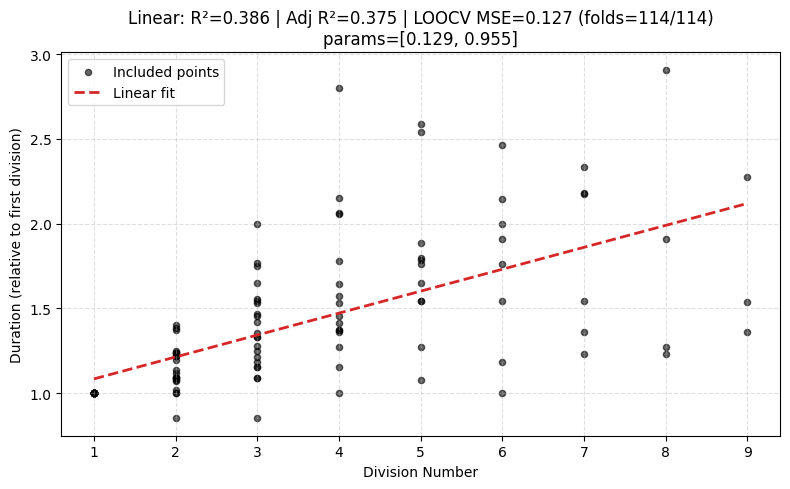

Included cells (linear ≥3): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [279]:
res_lin = fit_global_model(df_norm, linear, min_points=3)
plot_global_fit(res_lin, linear, model_name="Linear")
print("Included cells (linear ≥3):", res_lin["included_cells"])

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/3944861751.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errs.append(float((y[~mask] - y_pred)**2))


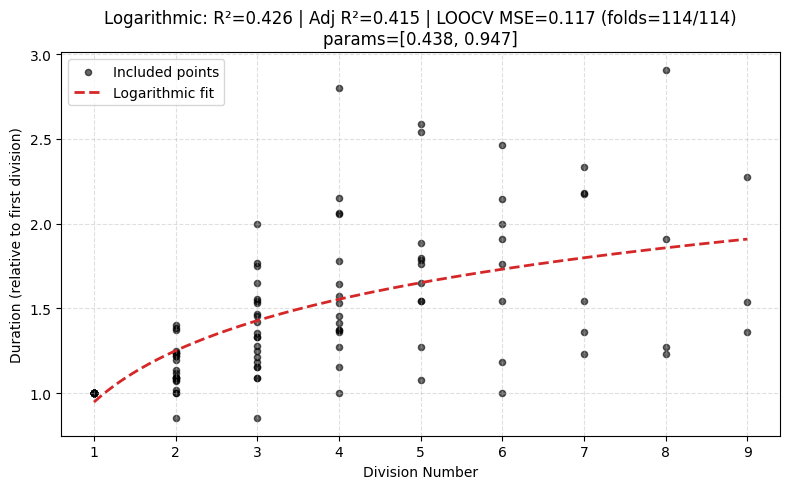

Included cells (logarithmic ≥3): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [280]:
res_lin = fit_global_model(df_norm, logarithmic, min_points=3)
plot_global_fit(res_lin, logarithmic, model_name="Logarithmic")
print("Included cells (logarithmic ≥3):", res_lin["included_cells"])

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/3944861751.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errs.append(float((y[~mask] - y_pred)**2))


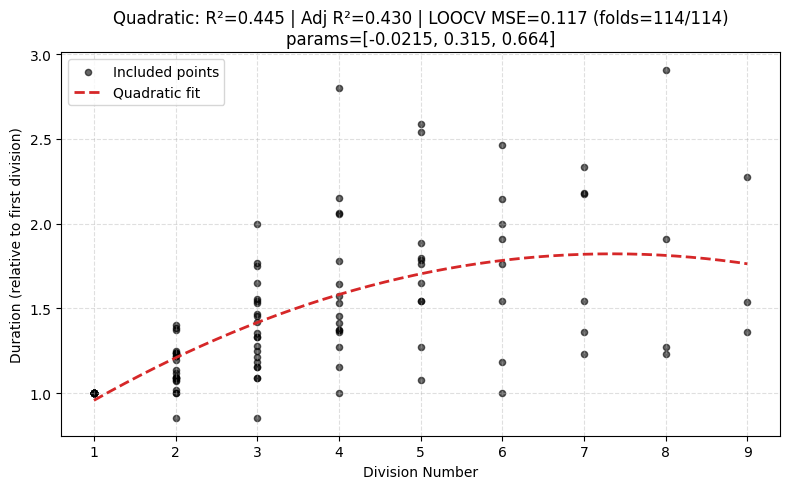

Included cells (quadratic ≥4): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [281]:
res_lin = fit_global_model(df_norm, quadratic, min_points=3)
plot_global_fit(res_lin, quadratic, model_name="Quadratic")
print("Included cells (quadratic ≥4):", res_lin["included_cells"])

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/3944861751.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errs.append(float((y[~mask] - y_pred)**2))


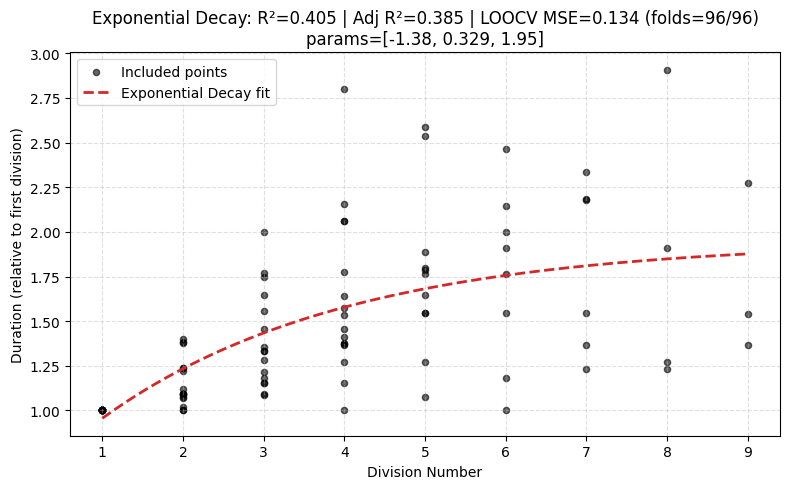

Included cells (exponential decay ≥4): [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [282]:
# crude p0: (a, b, c)
y_med = float(np.nanmedian(df_norm.values))
p0_exp = [max(0.1, np.nanmax(df_norm.values) - y_med), 0.3, y_med]

res_exp = fit_global_model(df_norm, exponential_decay, min_points=4, p0=p0_exp)
plot_global_fit(res_exp, exponential_decay, model_name="Exponential Decay")
print("Included cells (exponential decay ≥4):", res_lin["included_cells"])

/var/folders/2c/ggmnjcgs6zv79p4w57qtvtr80000gn/T/ipykernel_79171/3944861751.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errs.append(float((y[~mask] - y_pred)**2))


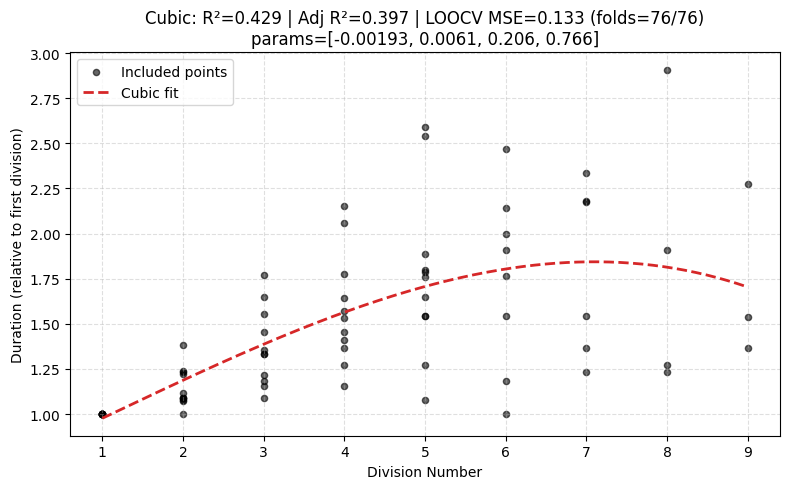

Included cells (cubic ≥5): [12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 24]


In [283]:
res_lin = fit_global_model(df_norm, cubic, min_points=5)
plot_global_fit(res_lin, cubic, model_name="Cubic")
print("Included cells (cubic ≥5):", res_lin["included_cells"])

## I think the logarithmic model has the best balance of complexity and performance here

---
Repeat for mudmut

In [ ]:
!wget https://github.com/Jannetty/Neurogen_ODE_Models/raw/main/mudmut_cellcycle_durations.xlsx -O mudmut_cellcycle_durations.xlsx

In [ ]:
df_raw = pd.read_excel("mudmut_cellcycle_durations.xlsx", header=None, engine="openpyxl")

# assign column names and set index
df_raw.columns = ['Division'] + list(range(1, df_raw.shape[1]))
df_raw.set_index('Division', inplace=True)

# convert to hours
def value_to_hours(val):
    if pd.isna(val):
        return np.nan

    # datetime.datetime or pandas Timestamp
    if isinstance(val, (datetime.datetime, pd.Timestamp)):
        return val.hour + val.minute / 60 + val.second / 3600

    # excel sometimes uses datetime.time
    if isinstance(val, datetime.time):
        return val.hour + val.minute / 60 + val.second / 3600

    # excel may store durations as fraction of a day
    if isinstance(val, (float, int)) and 0 <= val < 1:
        return val * 24

    return np.nan

df_hours = df_raw.applymap(value_to_hours)

df_hours = df_hours.reset_index()
# drop rows where 'Division' is missing/blank BEFORE extracting
df_hours = df_hours[df_hours['Division'].notna()]

df_hours["Division Number"] = (
    df_hours["Division"].astype(str).str.extract(r"(\d+)")[0].astype(float)
)
df_hours = df_hours.dropna(subset=["Division Number"])
df_hours["Division Number"] = df_hours["Division Number"].astype(int)

# set index and collapse duplicate division rows
df_hours = (
    df_hours.drop(columns=["Division"])
            .set_index("Division Number")
            .groupby(level=0).first()        # or .mean() if you prefer
            .sort_index()
)

In [ ]:
df_hours

In [ ]:
# normalize again
df_norm = df_hours.copy()
for cell in df_norm.columns:
    first_div = df_norm[cell].dropna().iloc[0]
    df_norm[cell] = df_norm[cell] / first_div

mean_durations = df_norm.mean(axis=1)
std_durations = df_norm.std(axis=1)

summary = pd.DataFrame({
    "Mean Duration (relative to first division)": mean_durations,
    "Std Dev (relative to first division)": std_durations
})

print(summary)

In [ ]:
df_norm

In [ ]:
df_long = df_norm.reset_index().melt(id_vars="Division Number", 
                                      var_name="Cell", 
                                      value_name="Duration (relative to first division)")
df_long = df_long.dropna()

summary = df_long.groupby("Division Number")["Duration (relative to first division)"].agg(["mean", "std"])

division_order = sorted(df_long["Division Number"].unique())

x_positions = list(range(len(division_order)))
mean_values = summary.loc[division_order, "mean"]
std_values = summary.loc[division_order, "std"]

plt.figure(figsize=(10, 6))
sns.stripplot(data=df_long, x="Division Number", y="Duration (relative to first division)",
              jitter=True, alpha=0.6, color='black', order=division_order)
plt.errorbar(x_positions, mean_values, yerr=std_values,
             fmt='o', color='red', capsize=4, label="Mean ± SD")

plt.title("mudmut Neuroblast Normalized Pooled Cell Cycle Durations")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("Division Number")
plt.ylabel("Cell Cycle Duration (relative to first division)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict

per_cell_fit_results = defaultdict(dict)

for cell in df_norm.columns:
    y = df_norm[cell].dropna()
    x = y.index.astype(float)
    y = y.values

    if len(x) >= 3: # enough points to fit 2 parameter models without default R^2 being 1
        for model_name, func in [("Linear", linear), ("Logarithmic", logarithmic)]:
                try:
                    params, _ = curve_fit(func, x, y)
                    y_pred = func(x, *params)
                    r2 = r_squared(y, y_pred)
                    per_cell_fit_results[model_name][cell] = {
                        "params": params,
                        "r2": r2
                    }
                    continue
                except:
                    continue

    if len(x) >=4: # enough points to fit quadratic, exponential decay, and cubic
        for model_name, func in [("Quadratic", quadratic), ("Exponential Decay", exponential_decay), ("Cubic", cubic)]:
            try:
                params, _ = curve_fit(func, x, y)
                y_pred = func(x, *params)
                r2 = r_squared(y, y_pred)
                per_cell_fit_results[model_name][cell] = {
                    "params": params,
                    "r2": r2
                }
            except:
                continue

In [ ]:
for cid in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    if cid in df_norm.columns:
        plot_cell_best_and_all_models(cid)

global fits:

In [ ]:
res_lin = fit_global_model(df_norm, linear, min_points=3)
plot_global_fit(res_lin, linear, model_name="Linear")
print("Included cells (linear ≥3):", res_lin["included_cells"])

In [ ]:
res_lin = fit_global_model(df_norm, logarithmic, min_points=3)
plot_global_fit(res_lin, logarithmic, model_name="Logarithmic")
print("Included cells (logarithmic ≥3):", res_lin["included_cells"])

In [ ]:
res_lin = fit_global_model(df_norm, quadratic, min_points=3)
plot_global_fit(res_lin, quadratic, model_name="Quadratic")
print("Included cells (quadratic ≥4):", res_lin["included_cells"])

In [ ]:
# crude p0: (a, b, c)
y_med = float(np.nanmedian(df_norm.values))
p0_exp = [max(0.1, np.nanmax(df_norm.values) - y_med), 0.3, y_med]

res_exp = fit_global_model(df_norm, exponential_decay, min_points=4, p0=p0_exp)
plot_global_fit(res_exp, exponential_decay, model_name="Exponential Decay")
print("Included cells (exponential decay ≥4):", res_lin["included_cells"])

In [ ]:
res_lin = fit_global_model(df_norm, cubic, min_points=5)
plot_global_fit(res_lin, cubic, model_name="Cubic")
print("Included cells (cubic ≥5):", res_lin["included_cells"])

### with 4 cells it is hard to say anything conclusive imo